### Notebook to investigate the intermediate shape representation used for HMR3
Shows that the pose does not affect the feature, and calculates & plots the distribution of feature with PCA

In [1]:
import sys
sys.path.append('../')

In [3]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import numpy as np

from data.eval_dataset import Dataset_3DPW
from data.eft_dataset import EFTDataset
from models.smpl import get_smpl_model
from data.display_utils import display_model

In [8]:
eval_dataset = Dataset_3DPW()
dataset = EFTDataset(datasets=['mpii'],is_train=False)

smpl_male = get_smpl_model(gender='male').to('cpu')
smpl = get_smpl_model().to('cpu')

In [9]:
def get_joints_feat(output,model):
    smpl_joints = output.joints[:,1:24,:] #has shape of [b,23,3], take all except the pelvis
    parents = model.parents[1:].unsqueeze(-1).unsqueeze(0)# has shape of [1,23,1]
    diff = smpl_joints - torch.take_along_dim(output.joints,parents,dim=1)
    joints_feat = torch.linalg.norm(diff,dim=-1)

    return joints_feat

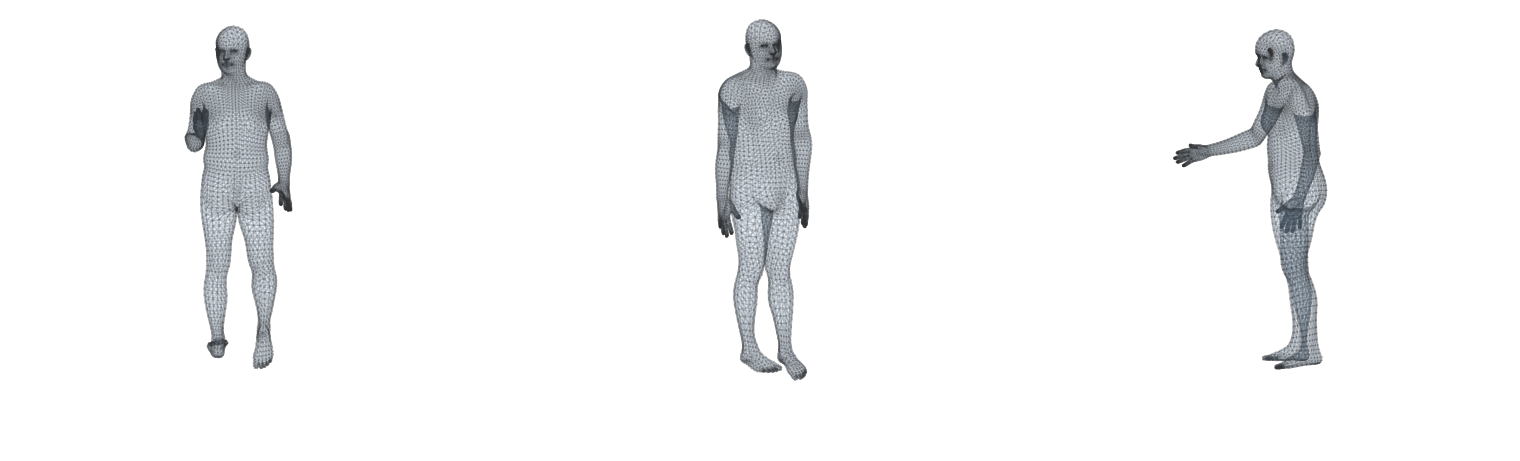

In [10]:
sample1 = eval_dataset[100]
sample2 = eval_dataset[1400]
sample3 = dataset[3000]

(sample1['shape']== sample2['shape']).all()

res_gt1 = smpl_male(global_orient=sample1['pose'].unsqueeze(0)[:,:3],body_pose=sample1['pose'].unsqueeze(0)[:,3:],betas=sample1['shape'].unsqueeze(0),pose2rot=True)
res_gt2 = smpl_male(global_orient=sample2['pose'].unsqueeze(0)[:,:3],body_pose=sample2['pose'].unsqueeze(0)[:,3:],betas=sample2['shape'].unsqueeze(0),pose2rot=True)
res_gt3 = smpl(global_orient=sample3['pose'].unsqueeze(0).flatten(2,3)[:,:1,:],body_pose=sample3['pose'].unsqueeze(0).flatten(2,3)[:,1:,:],betas=sample3['shape'].unsqueeze(0),pose2rot=False)

fig= plt.figure(figsize=(15,5))
ax1 = fig.add_axes(131,projection='3d')
ax2 = fig.add_axes(132,projection='3d')
ax3 = fig.add_axes(133,projection='3d')

ax1 = display_model(
            {'verts': res_gt1.vertices.cpu().detach(),
             'joints': res_gt1.joints[0,:24,:].cpu().detach()},
            model_faces=smpl_male.faces.astype(int),
            with_joints=False,
            kintree_table=smpl_male.parents,
            savepath=None,
            show=False,
            ax=ax1)
ax1.view_init(elev=-90,azim=-90)
ax1.set_axis_off()

ax2 = display_model(
            {'verts': res_gt2.vertices.cpu().detach(),
             'joints': res_gt2.joints[0,:24,:].cpu().detach()},
            model_faces=smpl_male.faces.astype(int),
            with_joints=False,
            kintree_table=smpl_male.parents,
            savepath=None,
            show=False,
            ax=ax2)
ax2.view_init(elev=-90,azim=-90)
ax2.set_axis_off()

ax3 = display_model(
            {'verts': res_gt3.vertices.cpu().detach(),
             'joints': res_gt3.joints[0,:24,:].cpu().detach()},
            model_faces=smpl.faces.astype(int),
            with_joints=False,
            kintree_table=smpl.parents,
            savepath=None,
            show=False,
            ax=ax3)
ax3.view_init(elev=-90,azim=-90)
ax3.set_axis_off()

In [11]:
joints_feat1 = get_joints_feat(res_gt1,smpl_male)
joints_feat2 = get_joints_feat(res_gt2,smpl_male)

print("Shapes:",joints_feat1.shape,joints_feat2.shape)
print("Are the same?:",(joints_feat1==joints_feat2).all())

Shapes: torch.Size([1, 23]) torch.Size([1, 23])
Are the same?: tensor(False)


In [13]:
joints_feat1,joints_feat2,sample1['shape'],sample2['shape']

(tensor([[0.1007, 0.1084, 0.1279, 0.3843, 0.3805, 0.1367, 0.4189, 0.4119, 0.0542,
          0.1381, 0.1441, 0.2041, 0.1288, 0.1345, 0.0986, 0.1229, 0.1124, 0.2442,
          0.2462, 0.2532, 0.2563, 0.0847, 0.0852]],
        grad_fn=<LinalgVectorNormBackward0>),
 tensor([[0.1050, 0.1123, 0.1328, 0.4043, 0.4036, 0.1367, 0.4515, 0.4452, 0.0544,
          0.1453, 0.1524, 0.2164, 0.1400, 0.1460, 0.1009, 0.1385, 0.1292, 0.2683,
          0.2756, 0.2770, 0.2803, 0.0903, 0.0918]],
        grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 0.9101,  0.4228,  1.3988, -1.5478,  0.3159,  0.9758,  0.7574,  0.0121,
         -1.3913, -0.7966]),
 tensor([-0.7491, -0.1769, -1.2609, -0.6331,  0.4938,  1.1087, -0.1686, -0.1368,
          0.2106,  0.9694]))

##### Distribution analysis

In [14]:
sample = dataset[0]
shape = sample['shape']
pose = sample['pose'].flatten(1,2).unsqueeze(0)

Check whether pose affects features

In [15]:
output1 = smpl(betas=shape.unsqueeze(0))
output2 = smpl(global_orient=pose[:,:1,:],body_pose=pose[:,1:,:],betas=shape.unsqueeze(0),pose2rot=False)

In [16]:
joints_feat1 = get_joints_feat(output1,smpl)
joints_feat2 = get_joints_feat(output2,smpl)


In [19]:
same = (joints_feat1==joints_feat2).all()
if same:
    print(True)
else:
    difference = torch.abs(joints_feat1-joints_feat2)
    print("Not exactly the same due to numerical errors. Max diff",difference.max().detach().item())

Not exactly the same due to numerical errors. Max diff 5.960464477539063e-08


In [20]:
loader = DataLoader(dataset,shuffle=False,batch_size=32,num_workers=4)
eval_loader = DataLoader(eval_dataset,shuffle=False,batch_size=64,num_workers=4)

In [17]:
smpl = smpl.to('cuda:3')
smpl_male = smpl_male.to('cuda:3')

In [21]:
results = torch.zeros(len(dataset),23,device='cuda:3')

for bn,batch in enumerate(loader):
    bs = batch['shape'].shape[0]

    shape = batch['shape'].to('cuda:3')
    pose = batch['pose'].to('cuda:3').flatten(2,3)

    output = smpl(global_orient=pose[:,:1,:],body_pose=pose[:,1:,:],betas=shape,pose2rot=False)
    joints_feat = get_joints_feat(output,smpl) #should be of shape [bs,23]

    results[bn*32:bn*32+bs] = joints_feat
    print(bn,end='\r')

In [106]:
eval_results = torch.zeros(len(eval_dataset),23,device='cuda:3')

for bn,batch in enumerate(eval_loader):
    bs = batch['shape'].shape[0]

    shape = batch['shape'].to('cuda:3')
    pose = batch['pose'].to('cuda:3')

    output = smpl(global_orient=pose[:,:3],body_pose=pose[:,3:],betas=shape)
    joints_feat = get_joints_feat(output,smpl) #should be of shape [bs,23]

    eval_results[bn*64:bn*64+bs] = joints_feat
    print(bn,end='\r')

In [4]:
load = True

pca = PCA(n_components=2)

if load:
    eval_results_np = np.load('results_3dpw.npy')
    results_np = np.load('results_cocoval.npy')
    results_np_mpii = np.load('results_mpii.npy')
else:
    eval_results_np = eval_results.detach().cpu().numpy()
    results_np = results.detach().cpu().numpy()

total_results_np = np.concatenate([results_np,results_np_mpii,eval_results_np],axis=0)
total_results_np_pca = pca.fit_transform(total_results_np)

#results_np_pca = pca.fit_transform(results_np)
#eval_results_np_pca = pca.transform(eval_results_np)

In [22]:
save = False
if save:
    np.save('results_cocoval',results_np)
    np.save('results_3dpw',eval_results_np)
    np.save('results_mpii',results.detach().cpu().numpy())

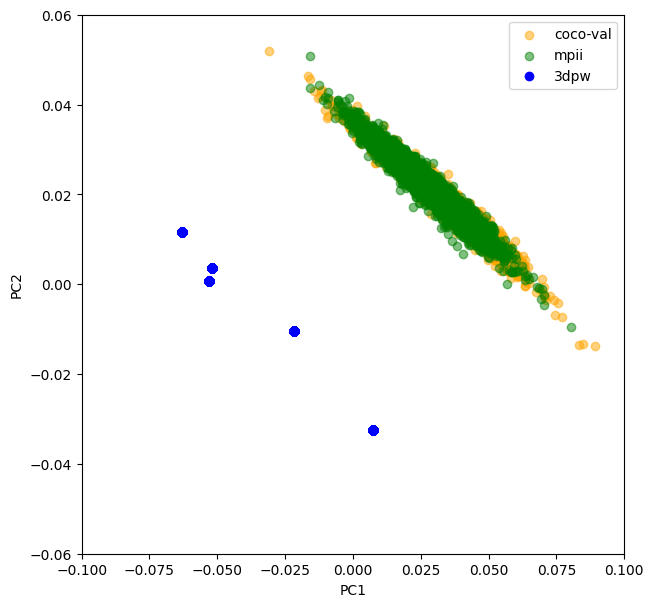

In [33]:
fig,ax = plt.subplots(1,1,figsize=(7,7))

#ax.scatter(results_np_pca[:,0],results_np_pca[:,1],c='orange')
#ax.scatter(eval_results_np_pca[:,0],eval_results_np_pca[:,1],c='blue')
ax.scatter(total_results_np_pca[:results_np.shape[0],0],total_results_np_pca[:results_np.shape[0],1],c='orange',label='coco-val',alpha=0.5)
ax.scatter(total_results_np_pca[results_np.shape[0]:results_np.shape[0]+results_np_mpii.shape[0],0],total_results_np_pca[results_np.shape[0]:results_np.shape[0]+results_np_mpii.shape[0],1],c='green',label='mpii',alpha=0.5)
ax.scatter(total_results_np_pca[results_np.shape[0]+results_np_mpii.shape[0]:,0],total_results_np_pca[results_np.shape[0]+results_np_mpii.shape[0]:,1],c='blue',label='3dpw')
ax.set_xlim((-0.1,0.1))
ax.set_ylim((-0.06,0.06))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()

In [7]:
kpca.explained_variance_ratio_.sum()

0.9859938